# Some visually good-looking experiments around Laplacians

_Author_: Louis Martinez

This notebook is inspired from this [tweet](https://x.com/gabrielpeyre/status/1884481605089255549) by Gabriel Peyré, about eigenvectors of the Laplacian. Images used for the experiments are screenshots from Google Image

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage.io import imread
from skimage.transform import resize
from scipy.sparse import lil_matrix # Construct sparse matrix incrementaly
from scipy.sparse.linalg import eigsh # Extract eigenvectors and eigenvalues

# For interactive plot
import ipywidgets as widgets
from IPython.display import display

def plot_eigenfunction(imgs: np.ndarray, k: int):
    plt.figure(figsize=(6, 6))
    divnorm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
    plt.imshow(imgs[:,:,k], cmap='coolwarm', norm=divnorm)
    plt.title(f"Eigenfunction {k}")
    plt.axis('off')
    plt.show()

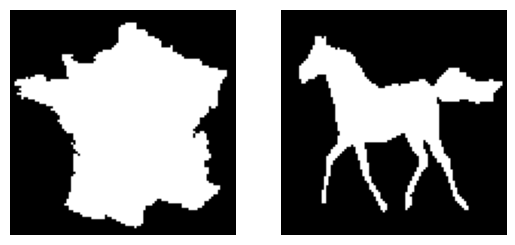

In [2]:
def load_img(path):
    img = imread(path)[...,0] # RGB by default
    img = resize(img, (100,100))
    img = (img - img.min()) / (img.max() - img.min())
    img = (img > 0.5).astype(float)
    return img

france = load_img('images/france.png')
horse = load_img('images/horse.png')

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(france, cmap='gray')
ax1.axis('off')
ax2.imshow(horse, cmap='gray')
ax2.axis('off')
plt.show()

We compute the Laplacian oeprator using finite difference (formula from Wikipedia)

$$\Delta f(x,y) \approx \frac{f(x-h,y) + f(x+h,y) + f(x,y-h) + f(x,y+h) - 4f(x,y)}{h^2}$$

where $h$ is the step size between two points. As we're working with images, thus regular grids, we set $h=1$

**Note**: In order to make the plots more aesthetic, eigen vectors are rescaled between -1 and 1.

In [ ]:
def compute_laplacian(img: np.ndarray):
    indices = np.argwhere(img > 0.5)
    indices_dict = {(row, col): i for i, (row, col) in enumerate(indices)}
    n_indices = len(indices)

    laplacian = lil_matrix((n_indices, n_indices), dtype=float)
    
    for i, (x, y) in enumerate(indices):
        laplacian[i, i] = -4  # Center pixel
        for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:  # Neighbors
            neigh = (x + dx, y + dy)
            if neigh in indices_dict:
                j = indices_dict[neigh]
                laplacian[i, j] = 1

    laplacian = laplacian.tocsr()  # Compress the matrix
    return laplacian, indices_dict

def compute_images(img, eigenvectors, indices_dict):
    n_eig = eigenvectors.shape[1]
    out = np.zeros(img.shape + (n_eig,), dtype=float)
    for k in range(n_eig):
        vec = eigenvectors[:,n_eig-1-k]
        vec = 2*(vec - vec.min()) / (vec.max() - vec.min()) - 1
        for (x, y), i in indices_dict.items():
            out[x, y, k] = vec[i]

    return out

def apply_projection(img, n_eigh):
    n_eig = n_eigh # number of eigenfunctions to compute
    laplacian, indices_dict = compute_laplacian(img)
    eigenvalues, eigenvectors = eigsh(laplacian, k=n_eig, which='SM')
    out = compute_images(img, eigenvectors, indices_dict)
    return out

We now try the program

In [4]:
n_eig = 50
out = apply_projection(france, n_eig)
# interactive plot
slider = widgets.IntSlider(min=0, max=n_eig-1, step=1, value=0, description='Eigenfunction')

def update(k):
    plt.clf()
    plot_eigenfunction(out, k)

widgets.interactive(update, k=slider)

interactive(children=(IntSlider(value=0, description='Eigenfunction', max=49), Output()), _dom_classes=('widge…

We also make a non intractive version

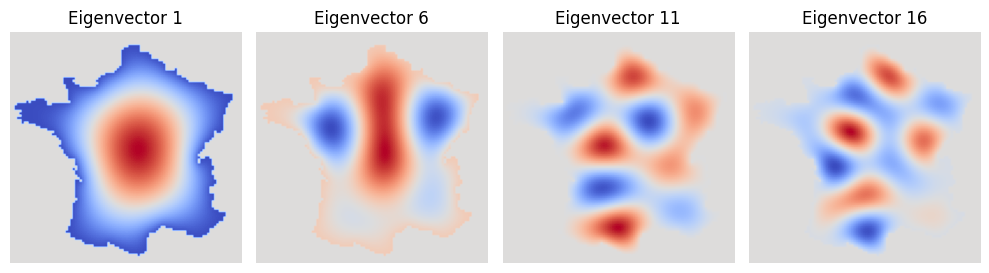

In [5]:
fig, ax = plt.subplots(1, 4, figsize=(10, 3))
divnorm = mcolors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
for i, a in enumerate(ax):
    eig_idk = i*5
    a.imshow(out[:,:,eig_idk], cmap='coolwarm', norm=divnorm)
    a.set_title(f'Eigenvector {eig_idk+1}')
    a.axis('off')
plt.tight_layout()
plt.show()

In [6]:
n_eig = 50
out = apply_projection(horse, n_eig)
# interactive plot
slider = widgets.IntSlider(min=0, max=n_eig-1, step=1, value=0, description='Eigenfunction')

def update(k):
    plt.clf()
    plot_eigenfunction(out, k)

widgets.interactive(update, k=slider)

interactive(children=(IntSlider(value=0, description='Eigenfunction', max=49), Output()), _dom_classes=('widge…

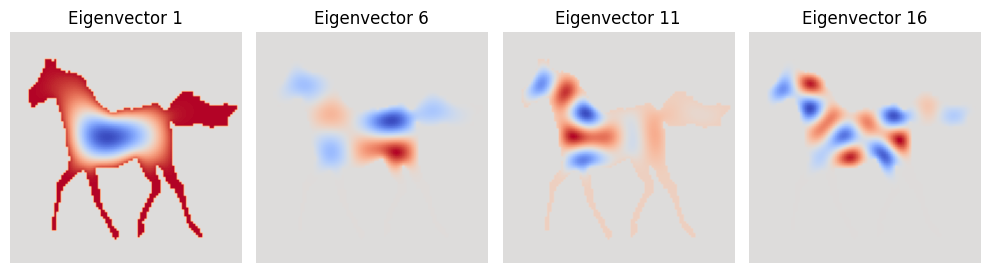

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(10, 3))
for i, a in enumerate(ax):
    eig_idk = i*5
    a.imshow(out[:,:,eig_idk], cmap='coolwarm', norm=divnorm)
    a.set_title(f'Eigenvector {eig_idk+1}')
    a.axis('off')
plt.tight_layout()
plt.show()

## Heat equation

